# Lab 6: Monte Carlo Methods & DP (2 points)

**Deadline**: Tuesday, May 21, 2024 at 11:59pm on Gradescope

## Installations

Ensure you have the following modules installed on your system:

* Numpy
* Matplotlib

You can install these modules using pip:

```bash
pip install numpy matplotlib
```

## Part 1: Estimating $\pi$ using Simple Monte Carlo Methods [1 point]

This part involves using the Monte Carlo method to estimate the value of $\pi$. You will simulate random point placements within a square to determine how many points fall inside a unit circle inscribed in the square. This method leverages probability and the geometric properties of the circle and the square to approximate the value of π.

Note that the area of a unit circle is $\pi \times 1^2 = \pi$. This unit circle is inscribed in a square with side length 2, so the area of the square is $2^2 = 4$. The ratio of the area of the circle to the area of the square is $\frac{\pi}{4}$. Therefore, the probability of a point falling inside the circle is $\frac{\pi}{4}$.

You are provided with a function template called `estimate_pi(num_samples, step)`. This function should simulate the placement of `num_samples` random points within a unit square and determine how many fall inside the inscribed unit circle.

**Tasks:**

* Implement the Monte Carlo logic inside the `estimate_pi` function to estimate $\pi$.
* Collect data periodically (as specified by the step parameter) for visualization purposes. This data should include:
  * Coordinates of points inside the circle.
  * Coordinates of points outside the circle.
  * The current estimate of $\pi$.

After implementing the functions, test your simulation with different numbers of samples and steps. Observe the accuracy and variability of your $\pi$ estimates over time.

The resulting visualization should be saved as a GIF file named `monte_carlo_pi.gif`. The GIF should show the progression of the Monte Carlo simulation over time with the estimated value of $\pi$ displayed on each frame. If you implemented it correctly, the estimated value of $\pi$ should converge to the actual value of $\pi = 3.14159...$ as the number of samples increases.

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from src.estimate_pi import estimate_pi

data = estimate_pi(100, step=1)

## Visualize the Monte Carlo Simulation

MovieWriter imagemagick unavailable; using Pillow instead.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


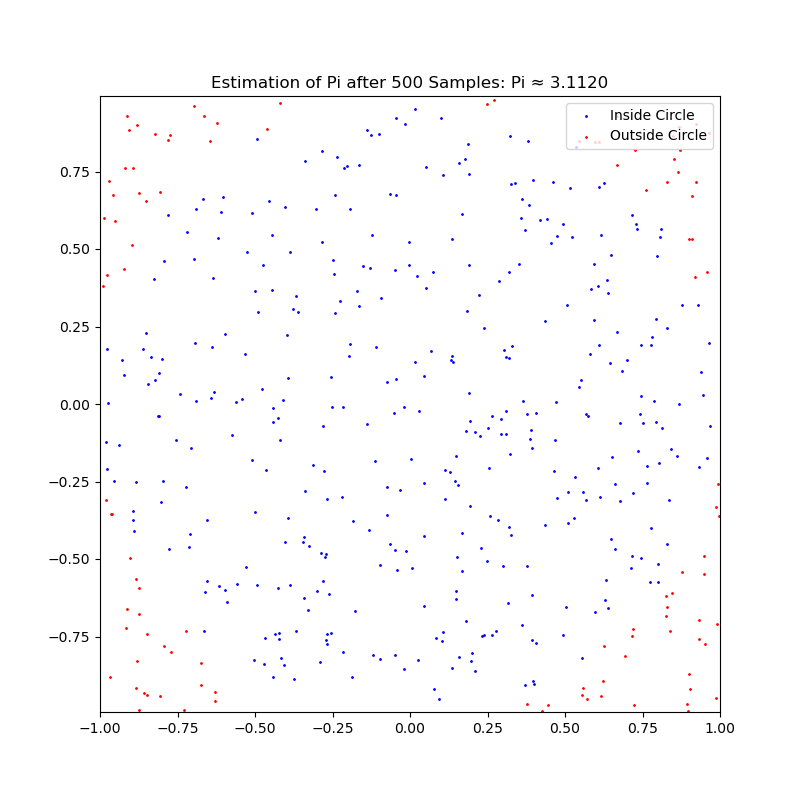

In [ ]:
#some assistance from chat gpt

from src.estimate_pi import create_animation_pi
from IPython.display import display, Image

# Reduce the sample size for testing if needed (e.g., 10,000)
num_samples = 50000  
step_size = 500  

# Create the animation and save it
create_animation_pi(num_samples, step=step_size, filename="monte_carlo_pi.gif")

# Display the saved GIF
display(Image(filename="monte_carlo_pi.gif"))


# Part 2: Dynamic Programming (DP) to solve Black Jack [1 point]

Blackjack is a popular card game played in casinos where the goal is to beat the dealer by having a hand value closer to 21 than the dealer’s hand without exceeding 21.

## Game Rule

### Card Values

- Number cards (2-10): Worth their face value.
- Face cards (J, Q, K): Worth 10 points each.
- Aces (A): Worth either 1 or 11 points, whichever benefits the player without exceeding 21.

### Game Setup

1. Each player and the dealer are dealt two cards.
    - Players’ cards are both face-up.
    - The dealer has one card face-up (the “upcard”) and one face-down (the “hole card”).
2. Players take turns deciding their actions before the dealer plays.

### Player Actions

After receiving the initial two cards, the player can choose one of the following actions:
1.	Hit → Take another card to increase the hand total.
2.	Stand (Stick) → Stop taking cards and keep the current hand total.
3.	Double Down → Double the bet and take exactly one more card.
4.	Split → If both initial cards are the same rank, split them into two separate hands, each with an additional bet.
5.	Surrender (if allowed) → Forfeit the round and get half of the bet back.
6.	Insurance (if dealer shows Ace) → A side bet that the dealer has Blackjack (pays 2:1).

### Dealer’s Turn

Once all players have completed their actions:
- The dealer reveals their hidden card.
- The dealer must draw until reaching at least 17:
- If the total is 16 or less, the dealer must draw another card.
- If the total is 17 or more, the dealer must stand.
- Some casinos require the dealer to hit on a “soft 17” (Ace + 6).

### Winning and Losing

Once the dealer finishes playing, hands are compared:
- Blackjack (Natural 21)
- A player with an Ace + 10-point card on the first two cards wins automatically unless the dealer also has a Blackjack (resulting in a tie).
- A Blackjack usually pays 3:2 (e.g., a $10 bet wins $15).
- Player Wins
- The player has a higher total than the dealer (without exceeding 21).
- The dealer busts (exceeds 21).
- Standard win pays 1:1.
- Player Loses
- The player busts (exceeds 21).
- The dealer’s total is higher than the player’s.
- Push (Tie)
- The player and dealer have the same total.
- The bet is returned to the player.

In [9]:
from src.blackjack import Card, Hand, BlackjackEnv

# create a cards list with 10 cards, from 1 to 10
cards = [Card(i + 1) for i in range(10)]

hand = Hand()
hand.add_card(cards[2])
hand.add_card(cards[7])
# now the hand is [3, 8]

In [10]:
# take a look at the hands and hand value
hand, hand.get_values()

(Hand(['Card(3)', 'Card(8)']), [11])

In [11]:
# create a new environment
env = BlackjackEnv()

# take a look at the initial state
next_state, reward, done = env.reset()  # (next_state, reward, done)

print("Initial State:", next_state)
print("Reward:", reward)
print("Done:", done)

Initial State: 18
Reward: 10
Done: True


## Game Formulations

For policy evaluation or value iteration, we typically define a value function:

$$
V(s) = \mathbb{E}[ \text{return} \mid s ]
$$

State space in Blackjack can be enumerated by:
- player_sum in $[4..21]$ (although typically we are more interested in $[12..21]$ because if your sum is < 12, you almost always want to hit).
- dealer_upcard in $[1..10]$.
- usable_ace in $\{True, False\}$.

Transitions:
- From state s, if the action is `HIT`:
    - We draw a new card. That leads us to a new state s' or we bust.
    - If we bust, we get a reward of -1 and transition to a terminal state.
- From state s, if the action is `STICK`:
    - The dealer draws. The outcome can be dealer bust (player wins, reward = +1) or final comparison (reward = +1, 0, or -1).

Expected Returns: we can compute expected returns by averaging over possible next cards (which appear with some probability).

## Policy Evaluation (Iterative)

3. Policy Evaluation (Iterative)

Policy Evaluation (a.k.a. Iterative Policy Evaluation) aims to solve:


$$
V_{k+1}(s) = \sum_a \pi(a \mid s) \sum_{s{\prime}, r} p(s{\prime}, r \mid s, a) \big[ r + \gamma V_k(s{\prime}) \big]
$$

In a standard Blackjack scenario, we typically take $\gamma = 1$ because it’s a finite episode with no ongoing discount, but you can also use $\gamma < 1$ if you want.

Algorithmically:
1. Initialize $V(s)$ to 0 (or random values) for all states.
2. Loop:
    - For each state $s$:
    - Calculate the new value:


$$
V_{new}(s) = \mathbb{E}_{a \sim \pi(\cdot|s), s{\prime}, r \sim p(\cdot|s, a)}\left[ r + \gamma V(s{\prime}) \right]
$$

- Update $V(s) ← V_{new}(s)$.
- Stop when changes are below some threshold or after a fixed number of iterations.

In [12]:
# Create the DP table
import numpy as np

# Constants / ranges
PLAYER_SUM_RANGE = range(4, 22)  # Though typically 12..21 is the main range
DEALER_UPCARD_RANGE = range(1, 11)
USABLE_ACE_RANGE = [False, True]
ACTIONS = [0, 1]  # 0->HIT, 1->STICK

from src.policy import initialize_value

V = initialize_value()
total_states = len(V)  # total number of states
print(f"Total number of states: {total_states}")

Total number of states: 360


We can create a simple policy to start with. For example, we can always stick if we have a sum more than 18, and we can always hit if we have a sum of 18 or less. This is a deterministic policy. Implement that policy in the `simple_policy` function.

In [13]:
from src.policy import simple_policy

policy_table = simple_policy()


# this means that at state 4, 1, 0, the policy is to HIT
state = (4, 1, 0)
action = policy_table[state]
print(f"The action for state {state} is: {'HIT' if action == 0 else 'STICK'}")

The action for state (4, 1, 0) is: HIT


### Policy Evaluation (Iterative)

We’ll do a simplified approach to policy evaluation. We can sample transitions or do a full expected update. Here, we show a Monte Carlo style sampling approach for policy evaluation (which is conceptually simpler, though not purely DP). For a purely dynamic-programming approach, you would compute the exact expectation by enumerating next card probabilities. In practice for Blackjack, this is typically feasible because there are only 13 card ranks.

In [14]:
from src.dp import policy_evaluation

env = BlackjackEnv()
V = initialize_value()
policy = simple_policy()

V = policy_evaluation(env, V, policy, episodes=500_000, gamma=1.0)

NameError: name 'defaultdict' is not defined

Based on the value generated by the policy evaluation, we can visualize the value function as a line graph based on the player sum. The x-axis should represent the player sum, while the y-axis should represent the value function.

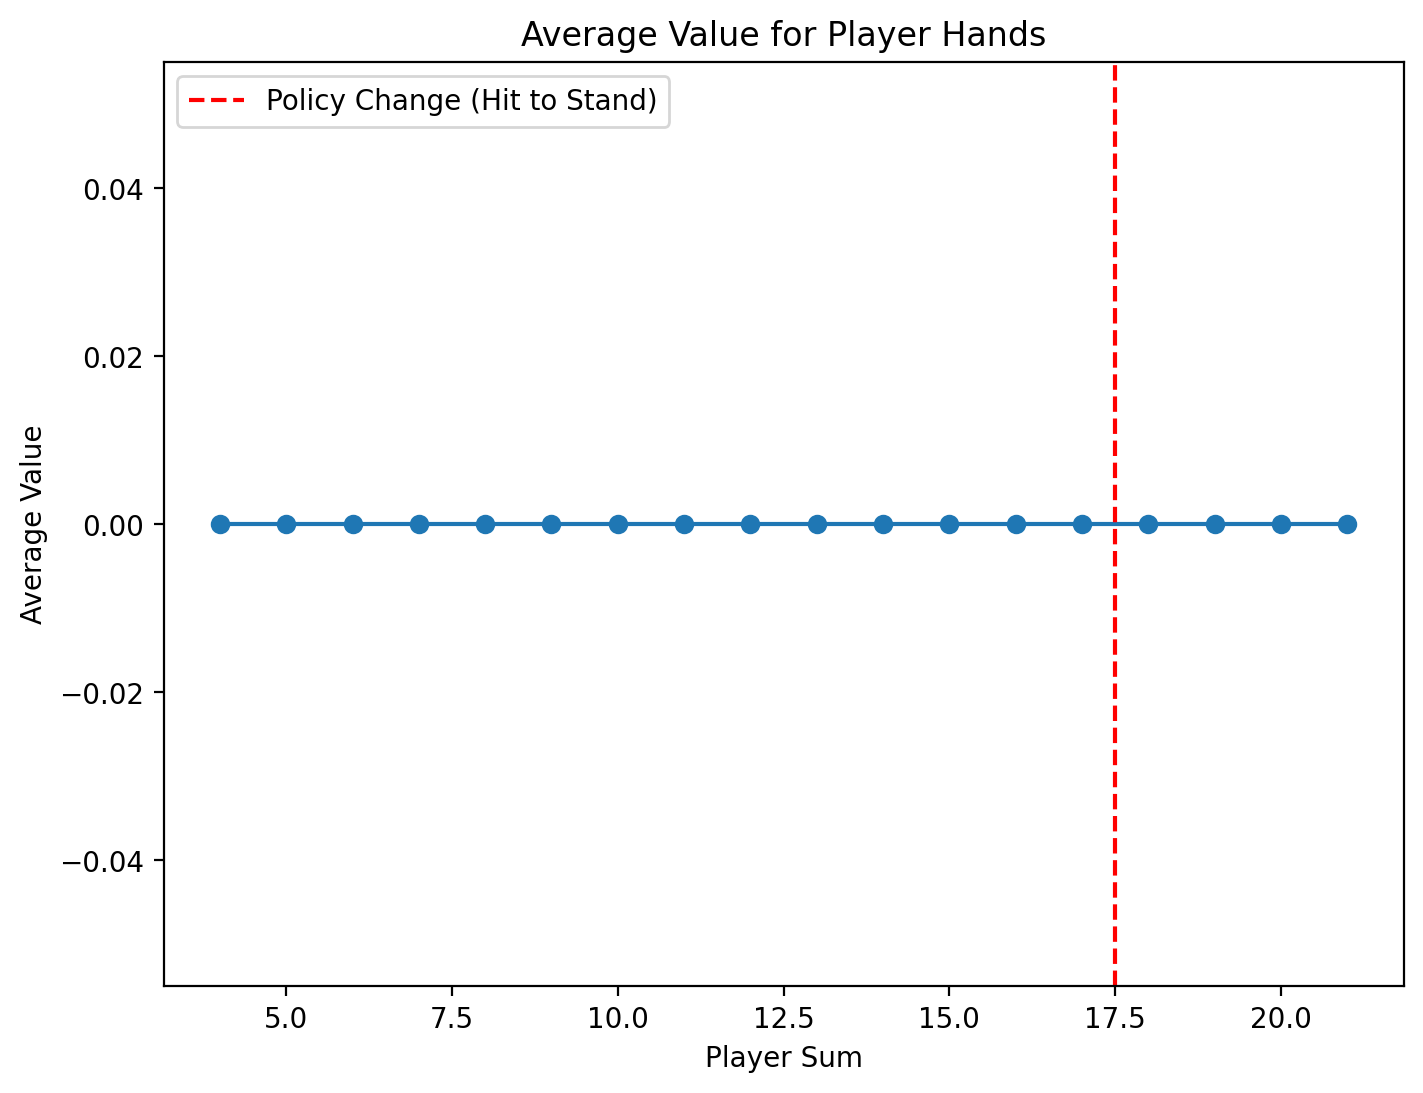

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Create a list of all possible player sums from the defined PLAYER_SUM_RANGE
player_sums = list(PLAYER_SUM_RANGE)

# Initialize an empty list to store the average value for each player sum
avg_values = []

# Iterate over every player sum in the range
for psum in player_sums:
    vals = []  # This list will collect the value function results for a fixed player sum over all dealer upcards and usable ace states
    
    # Loop through each possible dealer upcard value
    for dealer in DEALER_UPCARD_RANGE:
        # Loop through each usable ace state (True or False)
        for ace in USABLE_ACE_RANGE:
            state = (psum, dealer, ace)  # Define the current state as a tuple
            if state in V:
                # If the state exists in the value function dictionary V, append its value
                vals.append(V[state])
    
    # Calculate the average value for the current player sum
    # If there are values available, compute the average; otherwise, default to 0
    avg = sum(vals) / len(vals) if vals else 0
    # Append the computed average to the avg_values list
    avg_values.append(avg)

plt.figure(figsize=(8, 6))
plt.plot(player_sums, avg_values, marker="o")
plt.axvline(x=17.5, color="r", linestyle="--", label="Policy Change (Hit to Stand)")
plt.legend()
plt.xlabel("Player Sum")
plt.ylabel("Average Value")
plt.title("Average Value for Player Hands")
# submit this file to gradescope
plt.savefig("avg_values.png", dpi=200)
plt.show()

__Ungraded:__ Interpret the value graph in above in relationship between the player sum and the policy we created.

_Response:_ ...

# Testing:

You can test your implementation by running the following command in your directory that contains the `L6/tests`:

```bash
python -m unittest discover -s tests
```

# Submission

You need to submit the following files to Gradescope:

1. `monte_carlo_pi.gif`
2. `avg_value.png`
3. `blackjack.py`
4. `dp.py`
5. `policy.py`